<p style="font-size:36px;text-align:center"> <b>Personalized cancer diagnosis</b> </p>

<h1>>> Business Problem</h1>

<h2> Description</h2>
<p> Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/ </p>
<p> Data: Memorial Sloan Kettering Cancer Center (MSKCC)</p>
<p> Download training_variants.zip and training_text.zip from Kaggle.</p> 
<h6> Context:</h6>
<p> Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35336#198462</p>
<h6> Problem statement : </h6>
<h5>Classify the given genetic variations/mutations based on evidence from text-based clinical literature.</h5>

<h2> Real-world/Business objectives and constraints.</h2>
* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.

<h2> Assignments.</h2>
#### Task 1 : Apply all the ML models (as done in the first cut solution) on the i/p data vectorized by tf-Idf [Click Here](#Task1)
#### Task 2 : Apply Logistic regression with CountVectorizer features, including both unigrams and bigrams [Click Here](#Task2)


<h1>>> Machine Learning Problem Formulation</h1>
<h2> Data Overview</h2>

- Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data
- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that  human experts/pathologists use to classify the genetic mutations. 
- Both these data files are have a common column called ID
- <p> 
    Data file's information:
    <ul> 
        <li>
        training_variants (ID , Gene, Variations, Class)
        </li>
        <li>
        training_text (ID, Text)
        </li>
    </ul>
</p>

<h2> Mapping the real-world problem to an ML problem</h2>

<h3> Type of Machine Learning Problem</h3>
<p>
    
            There are nine different classes a genetic mutation can be classified into => Multi class classification problem
   
      
    
</p>

<h3> Performance Metric</h3>

Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment#evaluation

Metric(s): 
* Multi class log-loss 
* Confusion matrix 

<h3> Machine Learing Objectives and Constraints</h3>
<p> Objective: Predict the probability of each data-point belonging to each of the nine classes.
</p>
<p> Constraints:
</p>
* Interpretability
* Class probabilities are needed.
* Penalize the errors in class probabilites => Metric is Log-loss.
* No Latency constraints.

<h2> Train, CV and Test Datasets</h2>

Split the dataset randomly into three parts train, cross validation and test with 64%,16%, 20% of data respectively

<h1>>> Exploratory Data Analysis</h1>

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


C:\Users\ankan\AppData\Local\Programs\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<h2> Reading Data</h2>
<h3> Reading Gene and Variation Data</h3>
<p>
    training/training_variants is a comma separated file containing the description of the genetic mutations used for training. <br>
    Fields are 
    <ul>
        <li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>
    </ul>

In [7]:
data = pd.read_csv('training/training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


<h3> Reading Text Data</h3>

In [8]:
# note the seprator in this file
data_text =pd.read_csv("training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


<h3> Preprocessing of text</h3>

In [9]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not float : # handles the nan records
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()

        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "

        data_text[column][index] = string

In [10]:
# text pre-processing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    nlp_preprocessing(row['TEXT'], index, 'TEXT')
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

Time took for preprocessing the text : 234.33342283864582 seconds


In [11]:
# merge both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [12]:
# replace the nan records in TEXT column with the value 'empty'
nanRows = np.where(result['TEXT'].isnull().values == True)[0]
print(nanRows)
for i in nanRows:
    result['TEXT'][i] = 'empty'

[1109 1277 1407 1639 2755]


<h3> Test, Train and Cross Validation Split</h3>

We split the data into train, test and cross validation data sets, preserving the ratio of class distribution in the original data set

In [13]:
# Splitting data into train, test and cross validation (64:20:16)
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [14]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


<h2> Prediction using a 'Random' Model</h2>
<p style="font-size:16px"> In a 'Random' Model, we generate the NINE class probabilites randomly such that they sum to 1. And then we computed the log-loss for our model and found it to be roughly 2.5(for both CV and test dataset). These values serve as baseline for how badly our model can perform
<b>Note:</b> This exercise was already performed in the original file, so not attaching here</p>

<h2> Univariate Analysis</h2>
<p style="font-size:16px"> We performed univariate analysis for gene, variation and text feature and found them to be useful in one way or the other. Basically, we are not discarding any of the features <br>
<b>Note:</b> This exercise was already performed in the original file, so not attaching here</p>

<a id='Task1'>
# *Task 1: Use tf-Idf vectorizer to vectorize the data, select the top 1000 words based on tf-idf values for text feature and apply all the relevant ML models and report the log loss *</a>



<h2> Vectorize/Featurize the data (using tf-Idf)</h2>

In [27]:
# vectorize the gene feature
gene_vectorizer = TfidfVectorizer()
train_gene_feature = gene_vectorizer.fit_transform(train_df['Gene'])
# we use the same vectorizer that was trained on train data
test_gene_feature = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature = gene_vectorizer.transform(cv_df['Gene'])
print(train_gene_feature.shape,cv_gene_feature.shape,test_gene_feature.shape)

(2124, 239) (532, 239) (665, 239)


In [28]:
# vectorize the variation feature
variation_vectorizer = TfidfVectorizer()
train_variation_feature = variation_vectorizer.fit_transform(train_df['Variation'])
# we use the same vectorizer that was trained on train data
test_variation_feature = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature = variation_vectorizer.transform(cv_df['Variation'])
print(train_variation_feature.shape,cv_variation_feature.shape,test_variation_feature.shape)

(2124, 1951) (532, 1951) (665, 1951)


In [29]:
# vectorize the text feature 
text_vectorizer = TfidfVectorizer(min_df=3)
train_text_feature = text_vectorizer.fit_transform(train_df['TEXT'])
# we use the same vectorizer that was trained on train data
cv_text_feature = text_vectorizer.transform(cv_df['TEXT'])
test_text_feature = text_vectorizer.transform(test_df['TEXT'])
print(train_text_feature.shape,cv_text_feature.shape,test_text_feature.shape)

(2124, 53079) (532, 53079) (665, 53079)


In [44]:
# this method returns the indices of the most imp words according to tf-idf values
def getIndicesOf_topWords_From_TfIdf_Values(tf_idf_vect, final_tf_idf):
    feature_array = np.array(tf_idf_vect.get_feature_names())
    final_tf_idf_arr = final_tf_idf.toarray().sum(axis=0)
    
    topIndices = np.argsort(final_tf_idf_arr)[::-1]
    top_1000_indices = topIndices[0:1000]
    complete_most_imp_words = feature_array[topIndices]
    most_imp_words_subset = complete_most_imp_words[0:1000]
    
    return top_1000_indices,most_imp_words_subset

In [49]:
# Restrict the dimension of text feature to 1000(acc to tf-idf values)

# first we get the indices of the top 1000 words/features
top_1000_word_indices, top_1000_words = getIndicesOf_topWords_From_TfIdf_Values(text_vectorizer,train_text_feature)
print(top_1000_word_indices[0:5])
print(top_1000_words[0:5])

# now we restrict the dimension of the vectorized text feature in train, cv and test to 1000 
# using the top words fetched above
train_text_feature_1k = train_text_feature[:,top_1000_word_indices]
cv_text_feature_1k = cv_text_feature[:,top_1000_word_indices]
test_text_feature_1k = test_text_feature[:,top_1000_word_indices]

print(train_text_feature_1k.shape,cv_text_feature_1k.shape,test_text_feature_1k.shape)

[33217 10359 12074 51136 20441]
['mutations' 'brca1' 'cells' 'variants' 'fig']
(2124, 1000) (532, 1000) (665, 1000)


<h3> Now we stack the vectorized gene, variation and text features together to form our train, cv and test data-sets</h3>

In [54]:
# stack gene and variation first
train_gene_var = hstack((train_gene_feature,train_variation_feature))
test_gene_var = hstack((test_gene_feature,test_variation_feature))
cv_gene_var = hstack((cv_gene_feature,cv_variation_feature))
# now stack text finally
train_x = hstack((train_gene_var, train_text_feature_1k)).tocsr()
test_x = hstack((test_gene_var, test_text_feature_1k)).tocsr()
cv_x = hstack((cv_gene_var, cv_text_feature_1k)).tocsr()

# don't forget to normalize every feature
train_x = normalize(train_x, axis=0)
test_x = normalize(test_x, axis=0)
cv_x = normalize(cv_x, axis=0)

train_y = train_df['Class'].values
test_y = test_df['Class'].values
cv_y = cv_df['Class'].values

In [57]:
print("(no of data points * no of features) in train data = ", train_x.shape)
print("(no of data points * no of features) in test data = ", test_x.shape)
print("(no of data points * no of features) in cross validation data =", cv_x.shape)

(no of data points * no of features) in train data =  (2124, 3190)
(no of data points * no of features) in test data =  (665, 3190)
(no of data points * no of features) in cross validation data = (532, 3190)


<h3> We define some functions that will come handy later</h3>

In [64]:
# This function plots the confusion, precision and recall matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A = (((C.T)/(C.sum(axis=1))).T)
    B = (C/C.sum(axis=0))
    
    labels = [1,2,3,4,5,6,7,8,9]
    
    # representing C in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    # representing B in heatmap format
    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing A in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
def predict_and_plot_confusion_matrix(train_x, train_y, test_x, test_y, cv_x, cv_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belonging to each class
    predict_y = sig_clf.predict_proba(train_x)
    print("The train log-loss is : ",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
    predict_y = sig_clf.predict_proba(cv_x)
    print("The cross validation log-loss is : ",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    predict_y = sig_clf.predict_proba(test_x)
    print("The test log-loss is : ",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

<h1>>> Machine Learning Models</h1>

<h2> Base Line Model : Naive Bayes</h2>
<h3> Hyperparameter Tuning </h3>

for alpha = 1e-05
Log Loss : 1.1866869752012723
for alpha = 0.0001
Log Loss : 1.1815594651124977
for alpha = 0.001
Log Loss : 1.176897873501346
for alpha = 0.1
Log Loss : 1.2227197728009012
for alpha = 1
Log Loss : 1.4153078958050997
for alpha = 10
Log Loss : 1.7895623301813566
for alpha = 100
Log Loss : 1.8789138416630686
for alpha = 1000
Log Loss : 1.8387160861259007


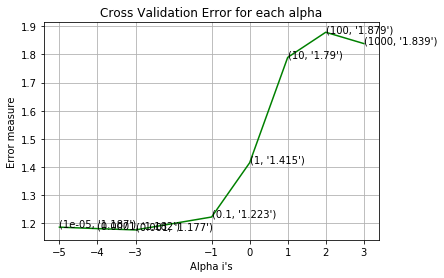

In [63]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


<h3> Testing the model with best hyperparameter </h3>

Best hyperparam :  0.001
The train log-loss is :  0.5105209849192183
The cross validation log-loss is :  1.176897873501346
The test log-loss is :  1.2041580255312812
Number of mis-classified points : 0.4030075187969925
-------------------- Confusion matrix --------------------


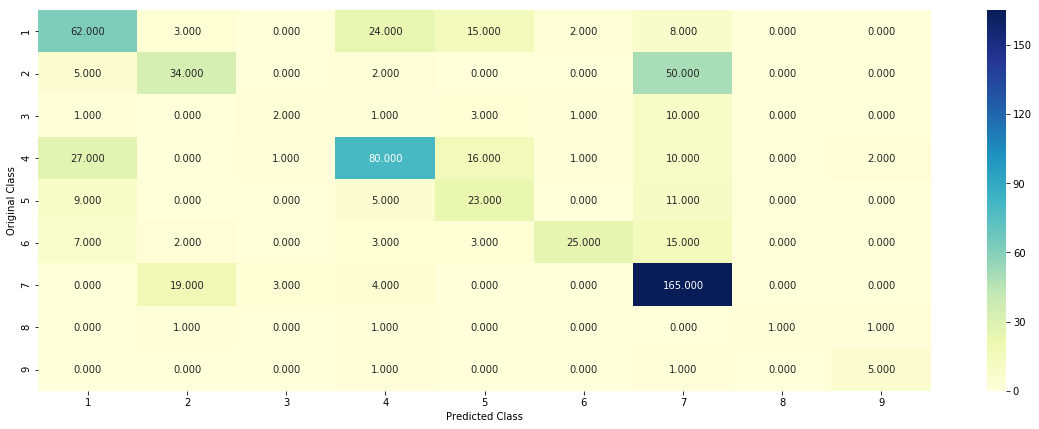

-------------------- Precision matrix (Columm Sum=1) --------------------


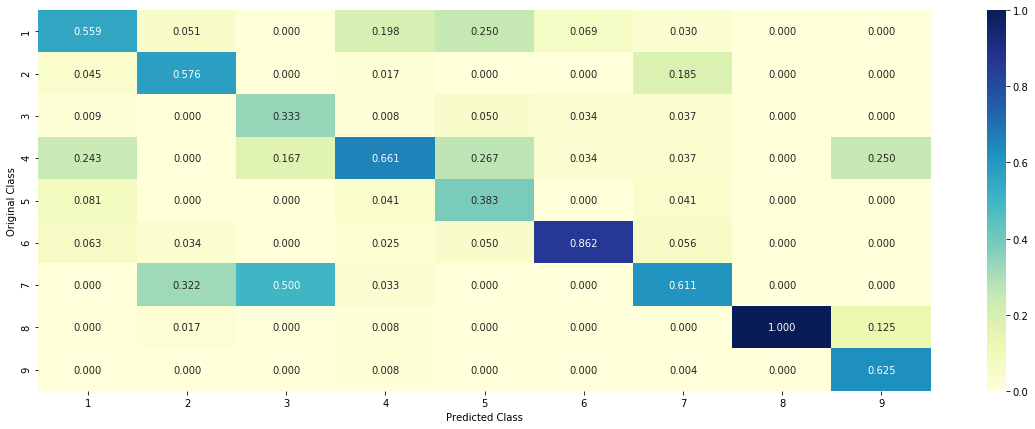

-------------------- Recall matrix (Row sum=1) --------------------


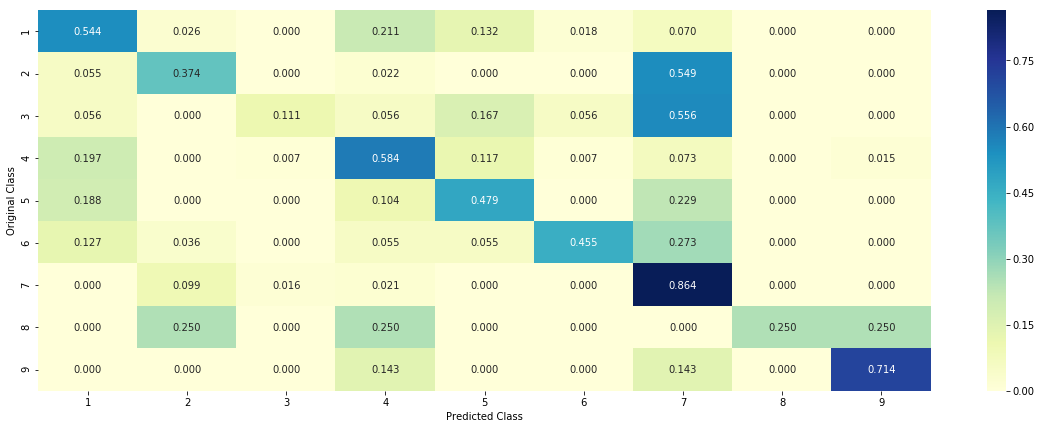

In [66]:
best_alpha = np.argmin(cv_log_error_array)
print('Best hyperparam : ',alpha[best_alpha])
clf = MultinomialNB(alpha=alpha[best_alpha])

predict_and_plot_confusion_matrix(train_x, train_y, test_x, test_y, cv_x, cv_y, clf)


<h2> k-NN </h2>
<h3> Hyperparameter Tuning </h3>

for alpha = 5
Log Loss : 1.4304351224136747
for alpha = 11
Log Loss : 1.3685928774323088
for alpha = 15
Log Loss : 1.3052596741296818
for alpha = 21
Log Loss : 1.31628550826426
for alpha = 31
Log Loss : 1.3844912297623029
for alpha = 41
Log Loss : 1.432228227440871
for alpha = 51
Log Loss : 1.4118365831823225


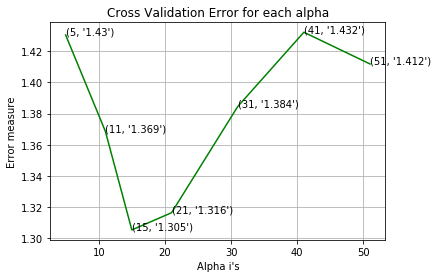

In [70]:
alpha = [5, 11, 15, 21, 31, 41, 51]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

<h3> Testing the model with best hyperparameter </h3>

Best hyperparam :  15
The train log-loss is :  1.2745044142770061
The cross validation log-loss is :  1.3052596741296818
The test log-loss is :  1.3058954800737808
Number of mis-classified points : 0.44511278195488724
-------------------- Confusion matrix --------------------


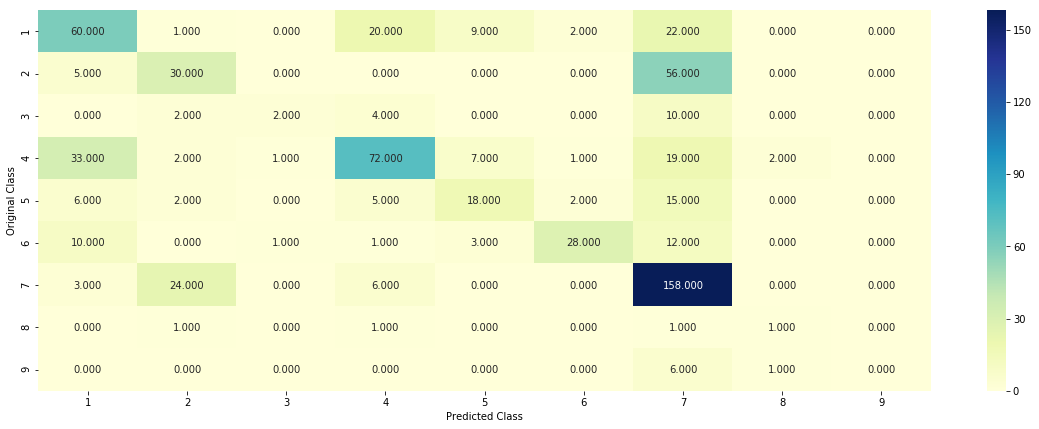

-------------------- Precision matrix (Columm Sum=1) --------------------


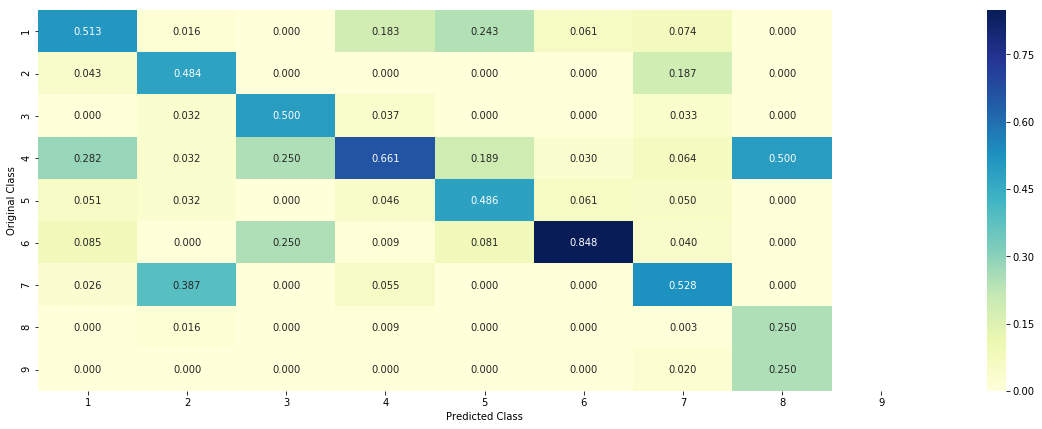

-------------------- Recall matrix (Row sum=1) --------------------


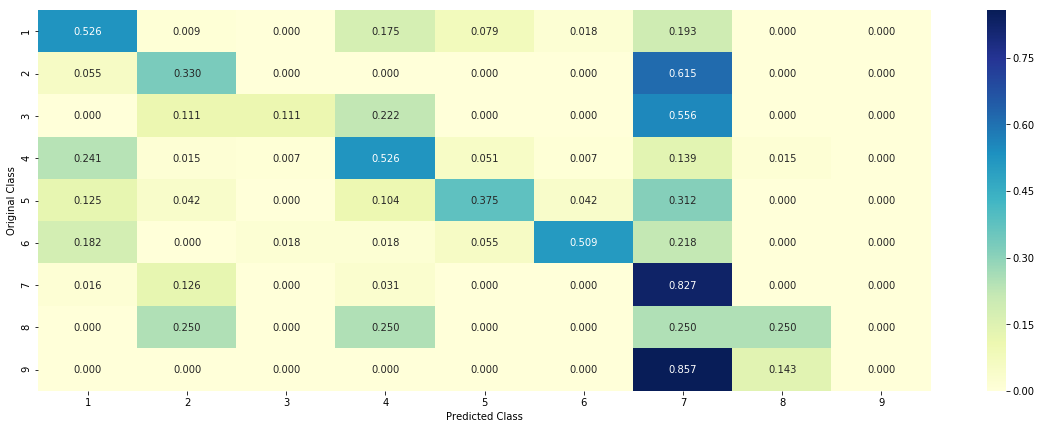

In [71]:
best_alpha = np.argmin(cv_log_error_array)
print('Best hyperparam : ',alpha[best_alpha])
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])

predict_and_plot_confusion_matrix(train_x, train_y, test_x, test_y, cv_x, cv_y, clf)


<h2> Logistic Regression with class-balancing </h2>
<h3> Hyperparameter Tuning </h3>

for alpha = 1e-06
Log Loss : 1.1292478647389448
for alpha = 1e-05
Log Loss : 1.0642547371775546
for alpha = 0.0001
Log Loss : 1.0392515574133918
for alpha = 0.001
Log Loss : 1.1484067318578093
for alpha = 0.01
Log Loss : 1.5174971186514385
for alpha = 0.1
Log Loss : 1.83311195007961
for alpha = 1
Log Loss : 1.874984724765915
for alpha = 10
Log Loss : 1.8792624397693913
for alpha = 100
Log Loss : 1.8797539038721165


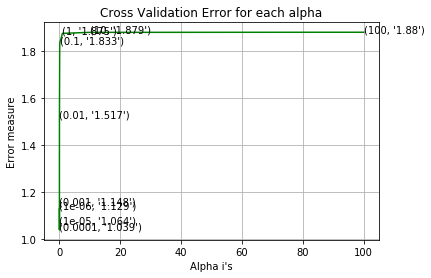

In [72]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

<h3> Testing the model with best hyperparameter </h3>

Best hyperparam :  0.0001
The train log-loss is :  0.414657812187291
The cross validation log-loss is :  1.0392515574133918
The test log-loss is :  1.0759140682506514
Number of mis-classified points : 0.362406015037594
-------------------- Confusion matrix --------------------


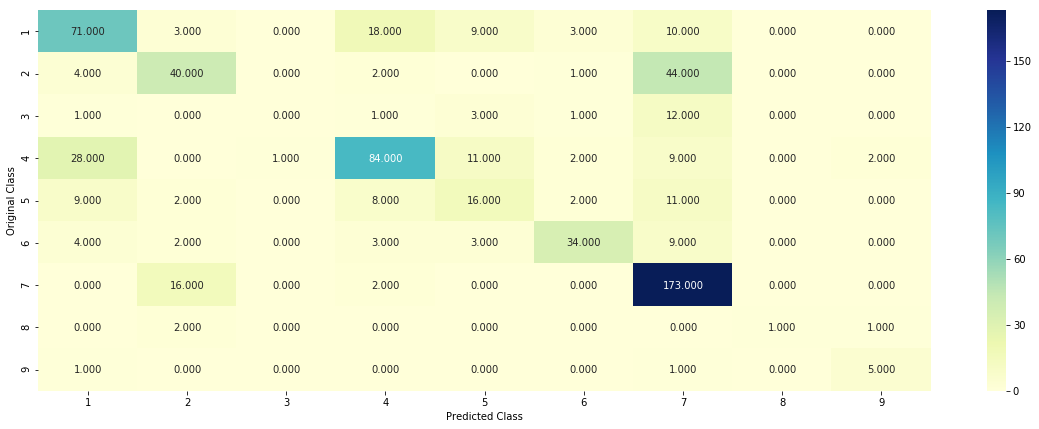

-------------------- Precision matrix (Columm Sum=1) --------------------


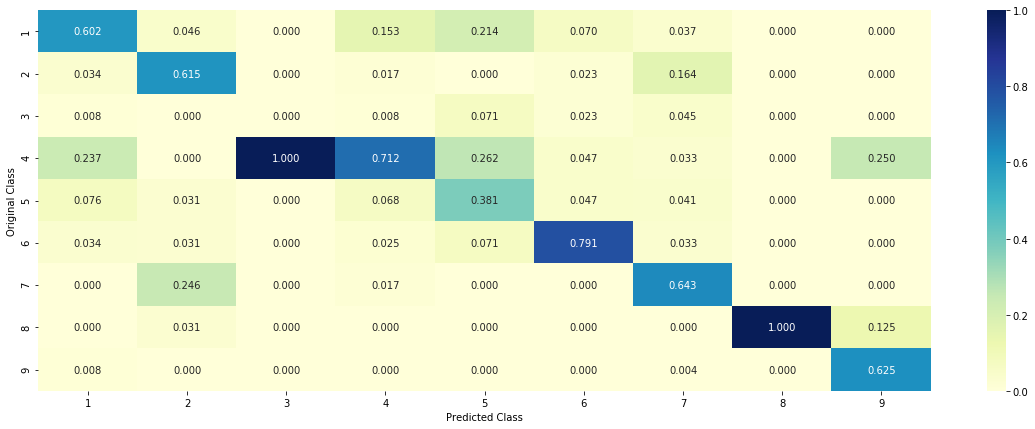

-------------------- Recall matrix (Row sum=1) --------------------


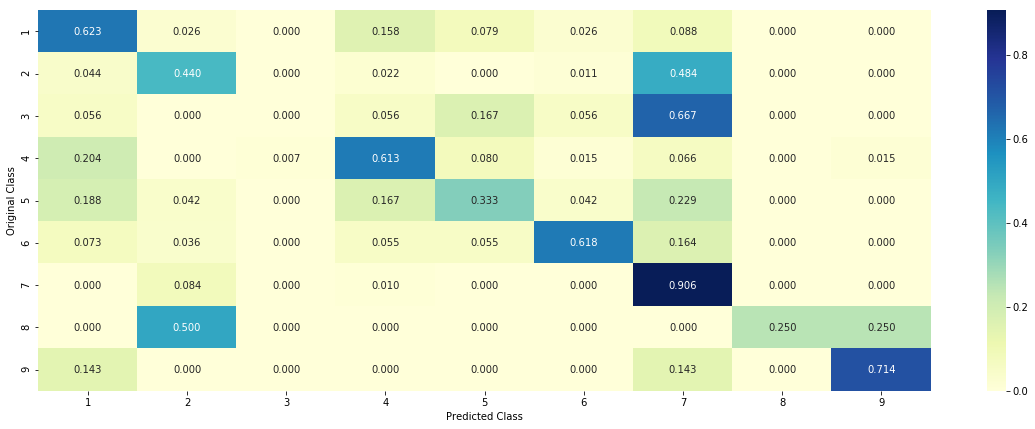

In [73]:
best_alpha = np.argmin(cv_log_error_array)
print('Best hyperparam : ',alpha[best_alpha])
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)

predict_and_plot_confusion_matrix(train_x, train_y, test_x, test_y, cv_x, cv_y, clf)


<h2> Logistic Regression without class-balancing </h2>
<h3> Hyperparameter Tuning </h3>

for alpha = 1e-06
Log Loss : 1.116460809250756
for alpha = 1e-05
Log Loss : 1.092970636465981
for alpha = 0.0001
Log Loss : 1.0634643640553891
for alpha = 0.001
Log Loss : 1.2391959584180658
for alpha = 0.01
Log Loss : 1.4313777532366974
for alpha = 0.1
Log Loss : 1.8657469171191687
for alpha = 1
Log Loss : 1.9053717754932278
for alpha = 10
Log Loss : 1.9084926265352993
for alpha = 100
Log Loss : 1.908832379777864


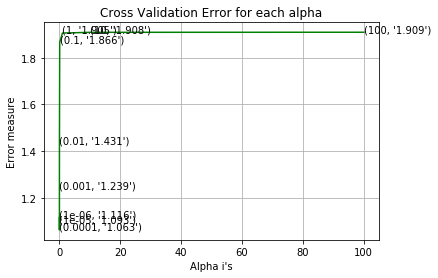

In [74]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

<h3> Testing the model with best hyperparameter </h3>

Best hyperparam :  0.0001
The train log-loss is :  0.411173799095319
The cross validation log-loss is :  1.0634643640553891
The test log-loss is :  1.0908136690023515
Number of mis-classified points : 0.37142857142857144
-------------------- Confusion matrix --------------------


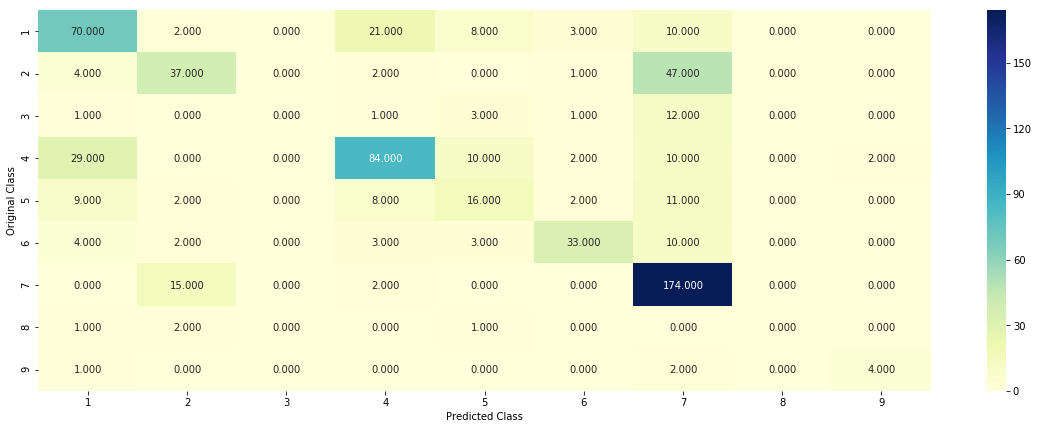

-------------------- Precision matrix (Columm Sum=1) --------------------


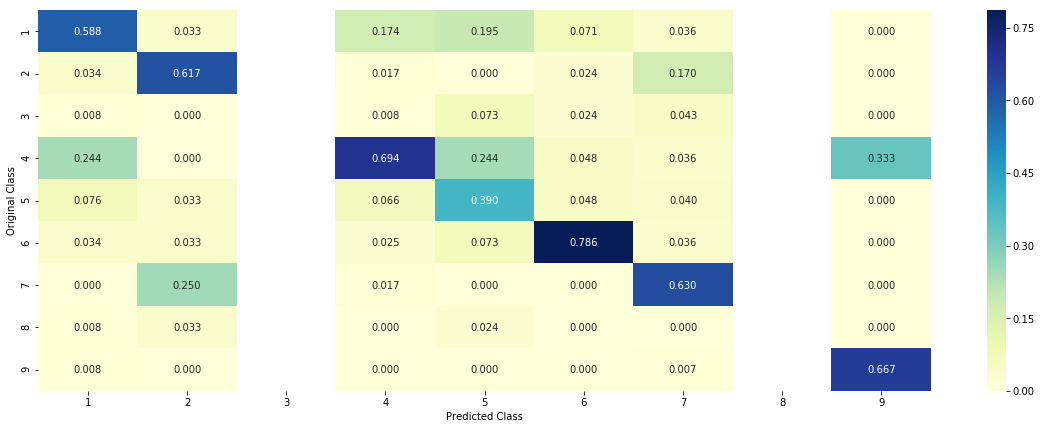

-------------------- Recall matrix (Row sum=1) --------------------


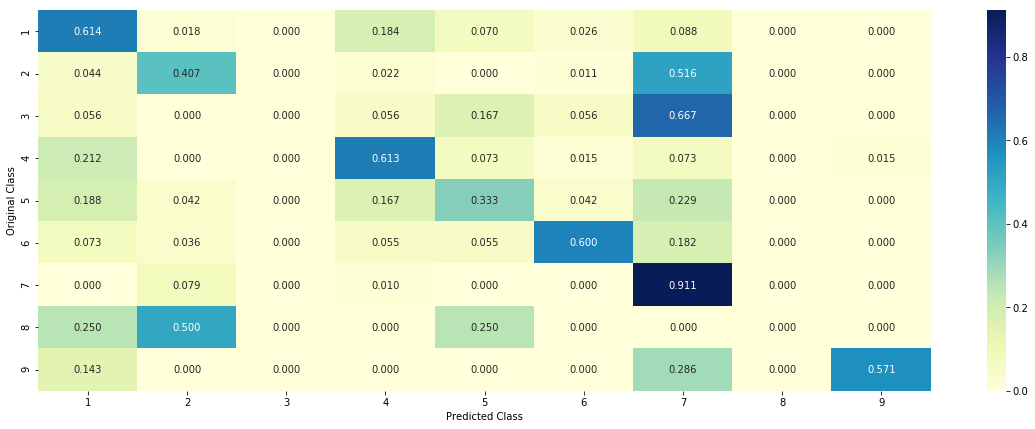

In [75]:
best_alpha = np.argmin(cv_log_error_array)
print('Best hyperparam : ',alpha[best_alpha])
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)

predict_and_plot_confusion_matrix(train_x, train_y, test_x, test_y, cv_x, cv_y, clf)


<h2> Linear SVM </h2>
<h3> Hyperparameter Tuning </h3>

for C = 1e-05
Log Loss : 1.1158580732493724
for C = 0.0001
Log Loss : 1.0371346969245545
for C = 0.001
Log Loss : 1.0557176957202348
for C = 0.01
Log Loss : 1.2948383041244895
for C = 0.1
Log Loss : 1.8631946557462302
for C = 1
Log Loss : 1.8798852804461923
for C = 10
Log Loss : 1.8798853237953317
for C = 100
Log Loss : 1.8798852713937637


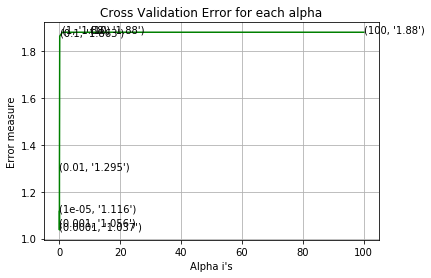

In [76]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

<h3> Testing the model with best hyperparameter </h3>

Best hyperparam :  0.0001
The train log-loss is :  0.4143305507709797
The cross validation log-loss is :  1.0371346969245545
The test log-loss is :  1.044113647776019
Number of mis-classified points : 0.37593984962406013
-------------------- Confusion matrix --------------------


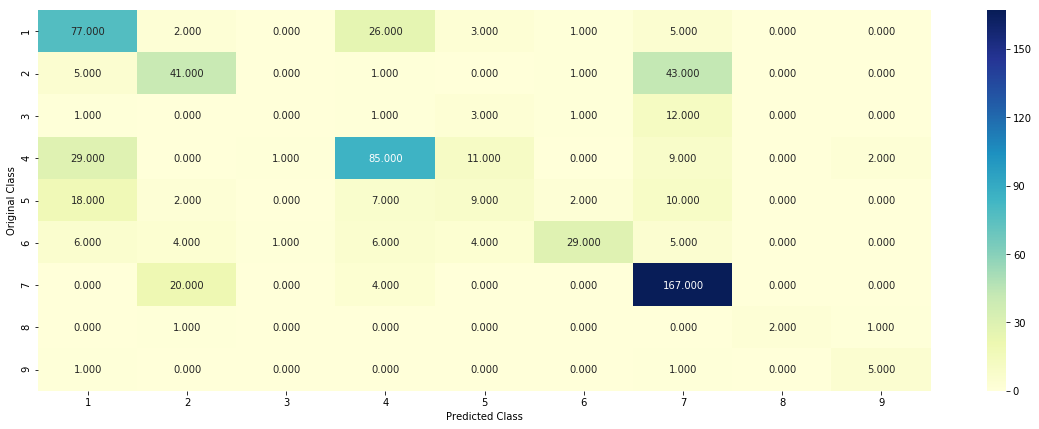

-------------------- Precision matrix (Columm Sum=1) --------------------


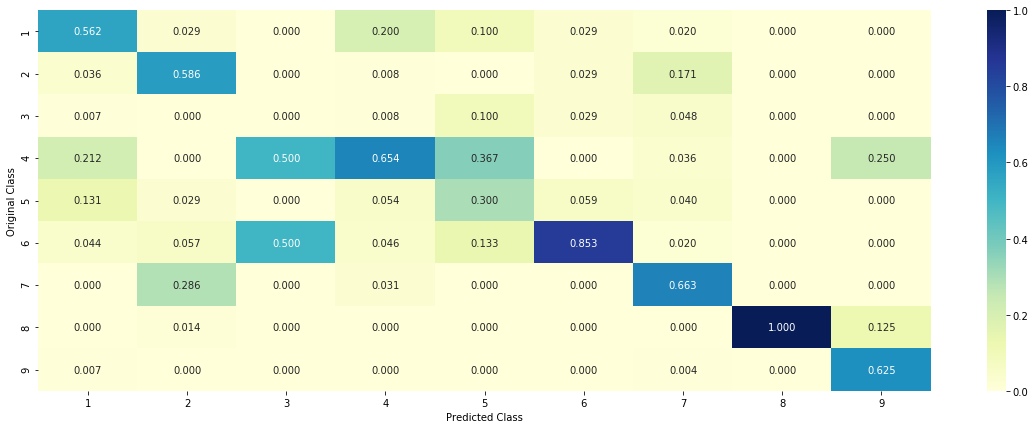

-------------------- Recall matrix (Row sum=1) --------------------


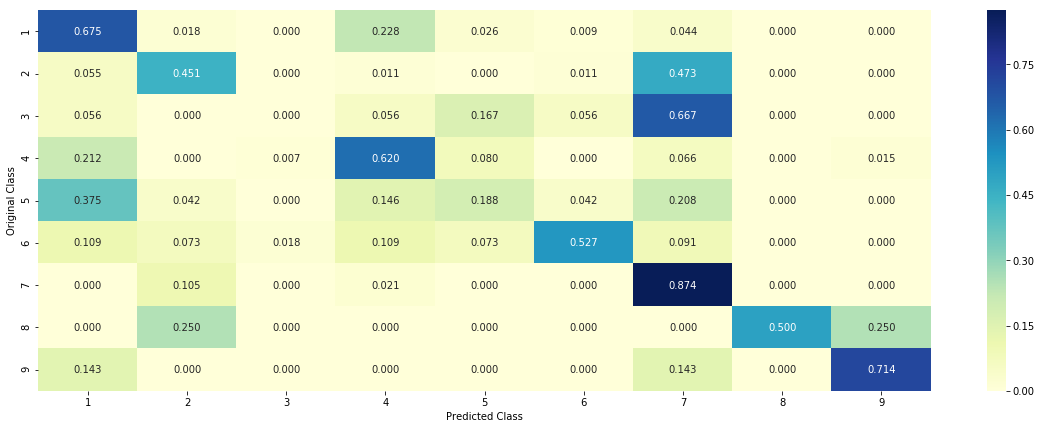

In [77]:
best_alpha = np.argmin(cv_log_error_array)
print('Best hyperparam : ',alpha[best_alpha])
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)

predict_and_plot_confusion_matrix(train_x, train_y, test_x, test_y, cv_x, cv_y, clf)


<h2> Random Forest </h2>
<h3> Hyperparameter Tuning </h3>

In [78]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
        

for n_estimators = 100 and max depth =  5
Log Loss : 1.186413958985633
for n_estimators = 100 and max depth =  10
Log Loss : 1.2046315664820495
for n_estimators = 200 and max depth =  5
Log Loss : 1.1702150204005253
for n_estimators = 200 and max depth =  10
Log Loss : 1.1845654051496186
for n_estimators = 500 and max depth =  5
Log Loss : 1.1558973087797457
for n_estimators = 500 and max depth =  10
Log Loss : 1.1773377019787055
for n_estimators = 1000 and max depth =  5
Log Loss : 1.1575026043152712
for n_estimators = 1000 and max depth =  10
Log Loss : 1.175280474957055
for n_estimators = 2000 and max depth =  5
Log Loss : 1.1554106831482465
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1722101234891649


<h3> Testing the model with best hyperparameter </h3>

Best hyperparams(n_estimators, max_depth) : (2000,5) 
The train log-loss is :  0.8932689579480259
The cross validation log-loss is :  1.1554106831482465
The test log-loss is :  1.1752855632674741
Number of mis-classified points : 0.4075187969924812
-------------------- Confusion matrix --------------------


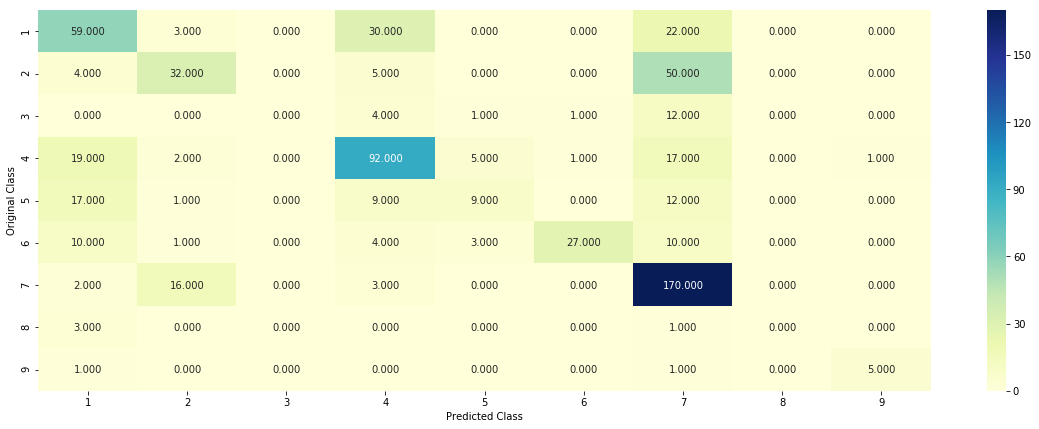

-------------------- Precision matrix (Columm Sum=1) --------------------


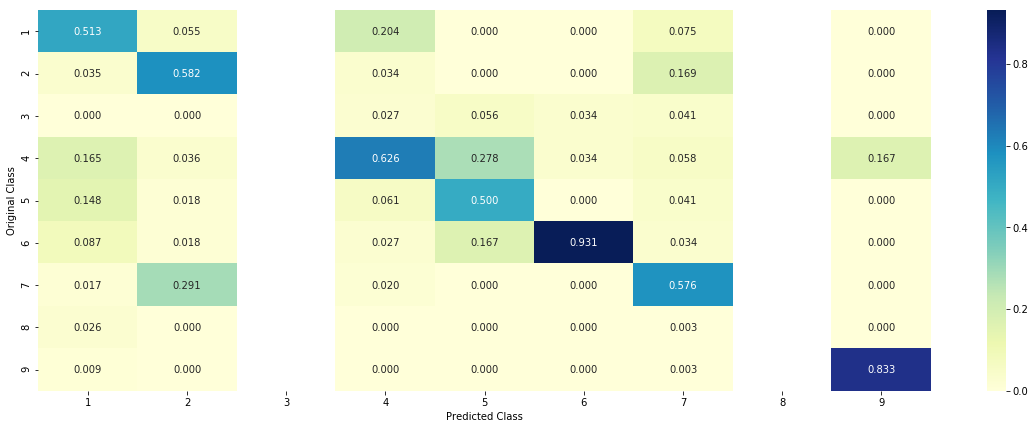

-------------------- Recall matrix (Row sum=1) --------------------


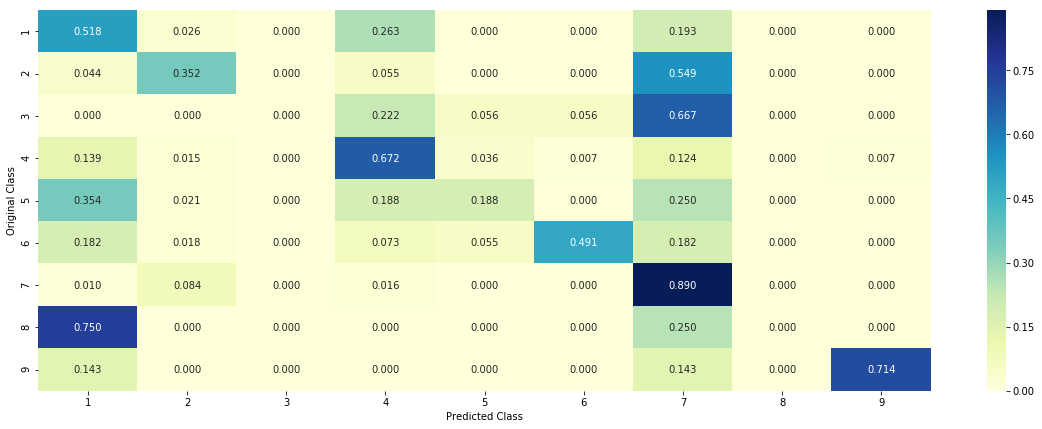

In [82]:
best_alpha = np.argmin(cv_log_error_array)
print('Best hyperparams(n_estimators, max_depth) : ({},{}) '.format(alpha[int(best_alpha/2)],max_depth[int(best_alpha%2)]))
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini',
                             max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)

predict_and_plot_confusion_matrix(train_x, train_y, test_x, test_y, cv_x, cv_y, clf)


<h2> Stacking Classifier </h2>
<h3> Hyperparameter Tuning { We choose (LR, lin SVM, NB) as our base models and LR as our stack model } </h3>

In [83]:
clf1 = SGDClassifier(alpha=0.0001, penalty='l2', loss='log', class_weight='balanced', random_state=42)
clf1.fit(train_x, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=0.0001, penalty='l2', loss='hinge', class_weight='balanced', random_state=42)
clf2.fit(train_x, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")

clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x))))
sig_clf2.fit(train_x, train_y)
print("Support Vector Machine : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x))))
sig_clf3.fit(train_x, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.04
Support Vector Machine : Log Loss: 1.04
Naive Bayes : Log Loss: 1.18
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.171
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.971
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.353
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.118
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.389
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.874


<h3> Testing the model with best hyperparameter </h3>

The train log-loss of the stacking classifier : 0.3081255702257832
The CV log-loss of the stacking classifier : 1.117928093072572
The test log-loss of the stacking classifier : 1.1898151317268
Number of mis-classified points : 0.37142857142857144
-------------------- Confusion matrix --------------------


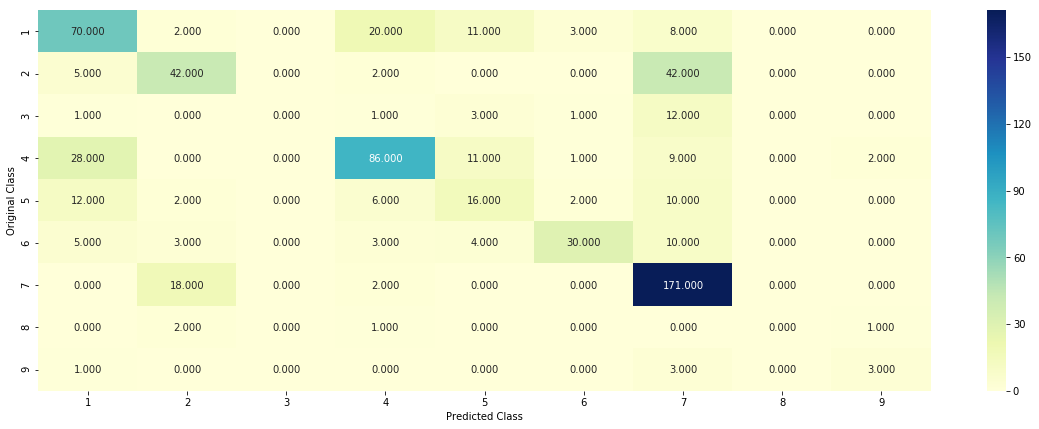

-------------------- Precision matrix (Columm Sum=1) --------------------


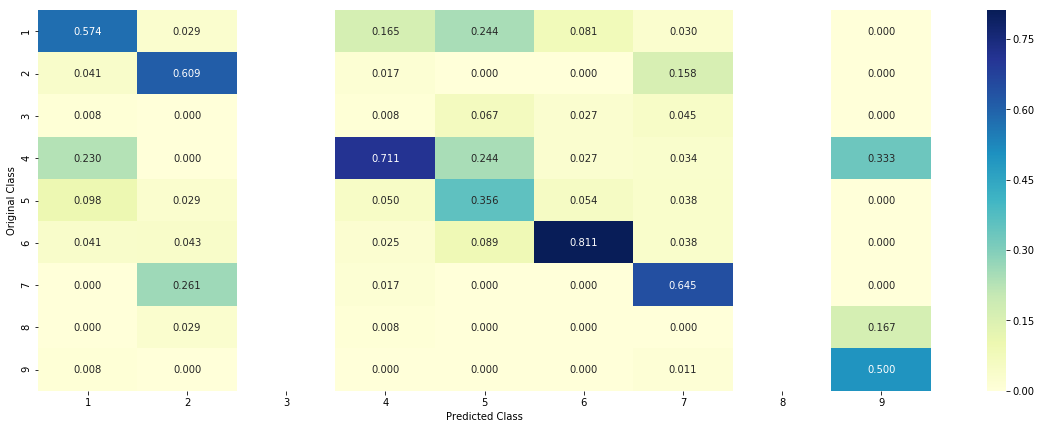

-------------------- Recall matrix (Row sum=1) --------------------


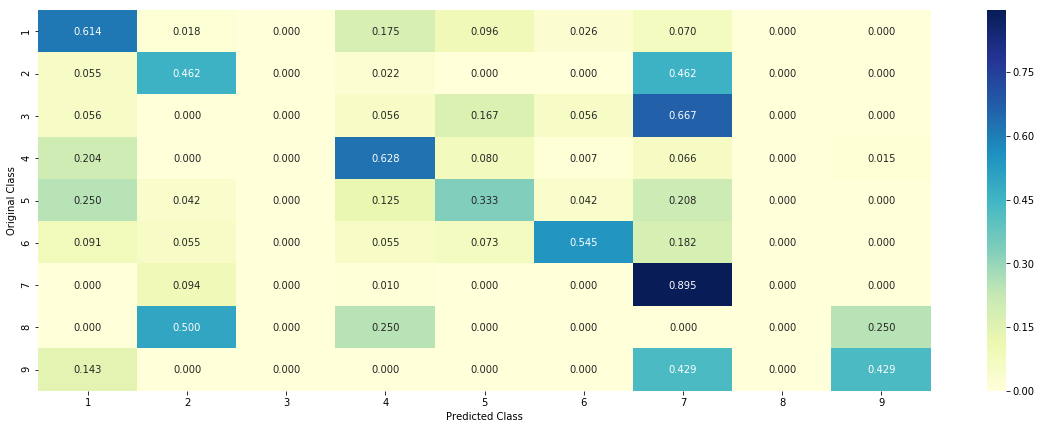

In [84]:
# From above, we can see that the best hyperparam for our stack model is 0.1
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x))
print("The train log-loss of the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x))
print("The CV log-loss of the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x))
print("The test log-loss of the stacking classifier :",log_error)

print("Number of mis-classified points :", np.count_nonzero((sclf.predict(test_x)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y, sclf.predict(test_x))


# Findings : 

<table align="left" style=width:80%>
  <tr>
    <th>Model Name</th>
    <th>Train log-loss</th> 
    <th>CV log-loss</th>
    <th>Test log-loss</th>
    <th>% of Misclassified Points</th>  
  </tr>
  <tr>
    <td>Naive Bayes</td>
    <td>0.511</td> 
    <td>1.177</td>
    <td>1.204</td>
    <td>40.3</td>  
  </tr>
  <tr>
    <td>k-NN</td>
    <td>1.275</td> 
    <td>1.305</td>
    <td>1.306</td>
    <td>44.51</td>  
  </tr>
  <tr>
      <td><b>LR with class balancing</b></td>
    <td>0.415</td> 
    <td>1.039</td>
      <td><b>1.076</b></td>
      <td><b>36.24</b></td>  
  </tr>
  <tr>
    <td>LR w/o class balancing</td>
    <td>0.411</td> 
    <td>1.063</td>
    <td>1.09</td>
    <td>37.14</td>  
  </tr>
  <tr>
    <td>Lin SVM</td>
    <td>0.414</td> 
    <td>1.037</td>
    <td>1.044</td>
    <td>37.59</td>  
  </tr>
  <tr>
    <td>Random Forest</td>
    <td>0.893</td> 
    <td>1.155</td>
    <td>1.175</td>
    <td>40.75</td>  
  </tr>
  <tr>
    <td>Stacking classifier</td>
    <td>0.308</td> 
    <td>1.118</td>
    <td>1.19</td>
    <td>37.14</td>  
  </tr>
   
</table>

<a id='Task2'>
# *Task 2: Use count vectorizer(both unigrams and bigrams) to vectorize the data, apply Logistic Regression and report the performance metric*</a>



<h2> Vectorize/Featurize the data (using BoW-bigrams)</h2>

In [100]:
# vectorize the gene feature
gene_vectorizer = CountVectorizer()
train_gene_feature = gene_vectorizer.fit_transform(train_df['Gene'])
# we use the same vectorizer that was trained on train data
test_gene_feature = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature = gene_vectorizer.transform(cv_df['Gene'])
print(train_gene_feature.shape,cv_gene_feature.shape,test_gene_feature.shape)

# vectorize the variation feature
variation_vectorizer = CountVectorizer()
train_variation_feature = variation_vectorizer.fit_transform(train_df['Variation'])
# we use the same vectorizer that was trained on train data
test_variation_feature = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature = variation_vectorizer.transform(cv_df['Variation'])
print(train_variation_feature.shape,cv_variation_feature.shape,test_variation_feature.shape)

# vectorize the text feature 
text_vectorizer = CountVectorizer(ngram_range=(1, 2),min_df=3)
train_text_feature = text_vectorizer.fit_transform(train_df['TEXT'])
# we use the same vectorizer that was trained on train data
cv_text_feature = text_vectorizer.transform(cv_df['TEXT'])
test_text_feature = text_vectorizer.transform(test_df['TEXT'])
print(train_text_feature.shape,cv_text_feature.shape,test_text_feature.shape)


(2124, 239) (532, 239) (665, 239)
(2124, 1951) (532, 1951) (665, 1951)
(2124, 782063) (532, 782063) (665, 782063)


<h3> Now we stack the vectorized gene, variation and text features together to form our train, cv and test data-sets</h3>

In [101]:
# stack gene and variation first
train_gene_var = hstack((train_gene_feature,train_variation_feature))
test_gene_var = hstack((test_gene_feature,test_variation_feature))
cv_gene_var = hstack((cv_gene_feature,cv_variation_feature))
# now stack text finally
train_x = hstack((train_gene_var, train_text_feature)).tocsr()
test_x = hstack((test_gene_var, test_text_feature)).tocsr()
cv_x = hstack((cv_gene_var, cv_text_feature)).tocsr()

# don't forget to normalize every feature
train_x = normalize(train_x, axis=0)
test_x = normalize(test_x, axis=0)
cv_x = normalize(cv_x, axis=0)

train_y = train_df['Class'].values
test_y = test_df['Class'].values
cv_y = cv_df['Class'].values

print("(no of data points * no of features) in train data = ", train_x.shape)
print("(no of data points * no of features) in test data = ", test_x.shape)
print("(no of data points * no of features) in cross validation data =", cv_x.shape)

(no of data points * no of features) in train data =  (2124, 784253)
(no of data points * no of features) in test data =  (665, 784253)
(no of data points * no of features) in cross validation data = (532, 784253)


<h2> Apply Logistic Regression </h2>
<h3> Hyperparameter Tuning </h3>

for alpha = 1e-06
Log Loss : 1.5886945923689149
for alpha = 1e-05
Log Loss : 1.5940180256522591
for alpha = 0.0001
Log Loss : 1.5983987548131087
for alpha = 0.001
Log Loss : 1.5318680966254528
for alpha = 0.01
Log Loss : 1.178102290860321
for alpha = 0.1
Log Loss : 1.1679188232593258
for alpha = 1
Log Loss : 1.2763406963464528
for alpha = 10
Log Loss : 1.3598951315417915
for alpha = 100
Log Loss : 1.375792652815174


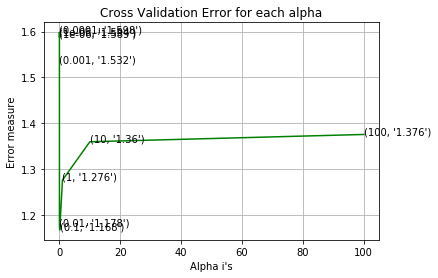

In [102]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

<h3> Testing the model with best hyperparameter </h3>

Best hyperparam :  0.1
The train log-loss is :  0.8882178954524399
The cross validation log-loss is :  1.1679188232593258
The test log-loss is :  1.204138644295118
Number of mis-classified points : 0.4105263157894737
-------------------- Confusion matrix --------------------


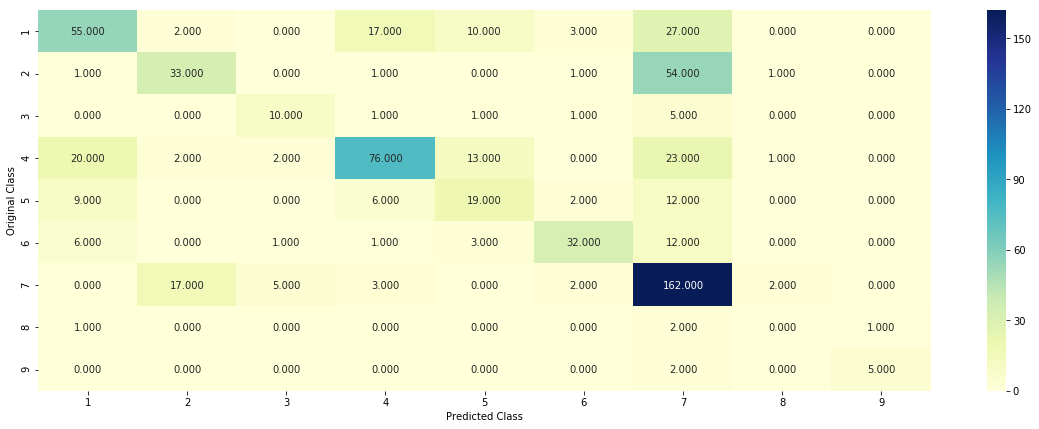

-------------------- Precision matrix (Columm Sum=1) --------------------


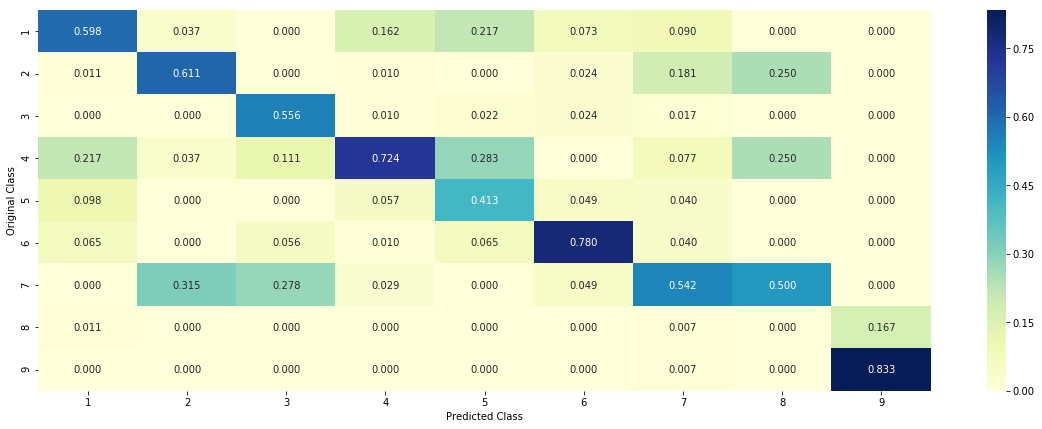

-------------------- Recall matrix (Row sum=1) --------------------


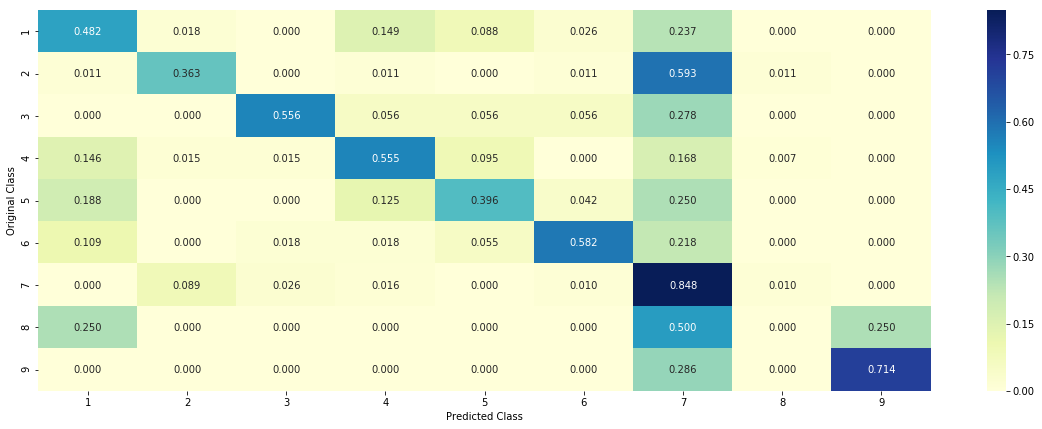

In [103]:
best_alpha = np.argmin(cv_log_error_array)
print('Best hyperparam : ',alpha[best_alpha])
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)

predict_and_plot_confusion_matrix(train_x, train_y, test_x, test_y, cv_x, cv_y, clf)


### Performance Metric(log-loss):


| __Model__ | __train log-loss__ |__cv log-loss__ | __test log-loss__ | __misclassified points(%)__ |
|:---|:---:|:---:|:---:|:---:|
|   LR | 0.888 | 1.168  | 1.204 | 41.05  | 